将观测到的和四个“理想”实验的甲烷浓度分解成趋势和波动。然后根据最有指纹法判断趋势和波动是否能被检测到。

In [83]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

In [84]:
import random
from PyEMD import EMD, EEMD
import pwlf

In [85]:
from scipy.stats import ttest_1samp,wilcoxon,binomtest 

# 趋势和波动分解

In [86]:
### EEMD ###

def cal_trend_EEMD(y,index_list=[2]):
    
    # Assign EEMD to `eemd` variable
    eemd = EEMD()

    # Say we want detect extrema using parabolic method
    emd = eemd.EMD
    emd.extrema_detection="parabol"

    S = np.array(y)
    t = np.arange(len(S))

    # Execute EEMD on S
    eIMFs = eemd.eemd(S, t)
    nIMFs = eIMFs.shape[0]

    trend = np.zeros_like(S)
    for i in index_list:
        trend += eIMFs[i]
    trend = trend + (np.mean(y)-np.mean(trend))
    var = S-trend
    return np.array([trend,var])

In [87]:
### 滑动平均 ###
def cal_trend_MA(y):
    y = np.array(y)
    MA_WIN=5
    temp = np.convolve(y, np.ones((MA_WIN,)), mode='valid') / MA_WIN
    trend = np.concatenate([np.array([np.nan,np.nan]),temp,np.array([np.nan,np.nan])])
    
    trend[0] = np.mean(y[:3])
    trend[1] = np.mean(y[:4])
    trend[-1] = np.mean(y[-3:])
    trend[-2] = np.mean(y[-4:])
    
    trend = trend + (np.nanmean(y)-np.nanmean(trend))
    var = y-trend
    return np.array([trend,var])

# ### 滑动平均(笨拙书写) ###
# def cal_trend_MA2(y):
#     ma = []
#     for i in range(len(y)):
#         if i<=1 or i>=len(y)-2:
#             ma.append(np.nan) 
#         else:
#             ma.append(np.mean(y[i-2:i+3]))    
#     trend = np.array(ma)
#     var = y-trend
#     return np.array([trend,var])

In [88]:
### 趋势线 ###
def cal_trend_PWLF(y,num=2):
    y = np.array(y)
    x = np.arange(len(y))
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    # fit the data for four line segments
    res = my_pwlf.fit(num)
    # predict for the determined points
    trend = my_pwlf.predict(x)
    trend = trend + (np.mean(y)-np.mean(trend))
    var = y-trend
    return np.array([trend,var])

# 数据读入

In [89]:
df = pd.read_csv('ex_data/concentration/ch4_incr.csv')[:-1]
obs_data = df['inc']

In [90]:
data = []
for i in range(72):
    text = 'results/ref/'+str(i+1)+'_ref.nc'
    with xr.open_dataset(text) as TMP: 
        TMP = TMP.load()
    data.append(TMP)
sim_data = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data])

In [91]:
data_without_emi = []
for i in range(72):
    text = 'results/none_but_one/emi/'+str(i+1)+'_ref.nc'
    with xr.open_dataset(text) as TMP: 
        TMP = TMP.load()
    data_without_emi.append(TMP)
sim_emi_data = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data_without_emi])

In [92]:
data_without_oh = []
for i in range(72):
    text = 'results/none_but_one/oh/'+str(i+1)+'_ref.nc'
    with xr.open_dataset(text) as TMP: 
        TMP = TMP.load()
    data_without_oh.append(TMP)
sim_oh_data = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data_without_oh])

In [93]:
data_without_wet = []
for i in range(72):
    text = 'results/none_but_one/wet/'+str(i+1)+'_ref.nc'
    with xr.open_dataset(text) as TMP: 
        TMP = TMP.load()
    data_without_wet.append(TMP)
sim_wet_data = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data_without_wet])

In [94]:
data_without_bio = []
for i in range(72):
    text = 'results/none_but_one/bio/'+str(i+1)+'_ref.nc'
    with xr.open_dataset(text) as TMP: 
        TMP = TMP.load()
    data_without_bio.append(TMP)
sim_bio_data = np.array([x.D_CH4.mean('config').diff('year')[2:] for x in data_without_bio])

# 画图与数据分析

In [95]:
def OLS(obs,sim):
    x = np.array(sim)
    y = np.array(obs)
    results = sm.OLS(y, x).fit()
    return results

## 趋势

In [96]:
trend_obs_EEMD = cal_trend_EEMD(obs_data)

In [97]:
trend_all = []
for i in range(72):
    temp = cal_trend_EEMD(sim_data[i])
    trend_all.append(temp)
trend_all_EEMD = np.array(trend_all)

In [98]:
params = []
for i in range(72):
    results = OLS(trend_obs_EEMD[0],trend_all_EEMD[i,0,:])
    params.append(results.params)
params_all_trend = np.array(params)

params = []
for i in range(72):
    results = OLS(trend_obs_EEMD[1],trend_all_EEMD[i,1,:])
    params.append(results.params)
params_all_variability = np.array(params)

In [99]:
trend_emi = []
for i in range(72):
    temp = cal_trend_EEMD(sim_emi_data[i])
    trend_emi.append(temp)
trend_emi_EEMD = np.array(trend_emi)

trend_oh = []
for i in range(72):
    temp = cal_trend_EEMD(sim_oh_data[i])
    trend_oh.append(temp)
trend_oh_EEMD = np.array(trend_oh)

trend_wet = []
for i in range(72):
    temp = cal_trend_EEMD(sim_wet_data[i])
    trend_wet.append(temp)
trend_wet_EEMD = np.array(trend_wet)

trend_bio = []
for i in range(72):
    temp = cal_trend_EEMD(sim_bio_data[i])
    trend_bio.append(temp)
trend_bio_EEMD = np.array(trend_bio)

In [100]:
params = []
for i in range(72):
    temp = np.array([trend_emi_EEMD[i,0,:],trend_oh_EEMD[i,0,:],trend_wet_EEMD[i,0,:],trend_bio_EEMD[i,0,:]])
    results = OLS(trend_obs_EEMD[0],temp.T)  
    params.append(results.params)
params_trend = np.array(params)

params = []

for i in range(72):
    temp = np.array([trend_emi_EEMD[i,1,:],trend_oh_EEMD[i,1,:],trend_wet_EEMD[i,1,:],trend_bio_EEMD[i,1,:]])
    results = OLS(trend_obs_EEMD[1],temp.T) 
    params.append(results.params)

params_variability = np.array(params)

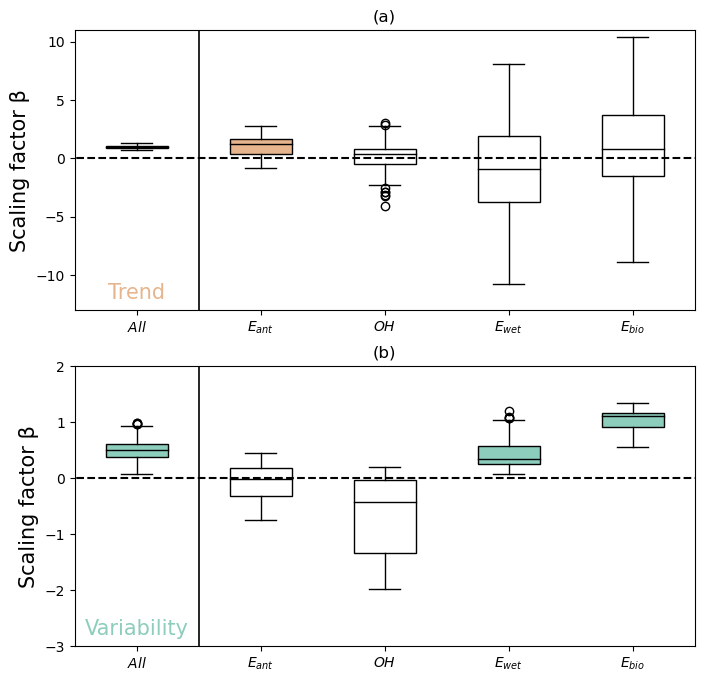

In [107]:
trend = np.concatenate([params_all_trend.T,params_trend.T]).T
variability = np.concatenate([params_all_variability.T,params_variability.T]).T

fig=plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((2,1),(0,0),rowspan=1)
bplot = ax1.boxplot(trend,patch_artist=True)
# temp = sns.violinplot(data=trend, bw_adjust=.5, cut=1, linewidth=1, palette=['#e7b58d','#e7b58d','#e7b58d','w','w'])
ax1.set_title('(a)')

for i in [0,1,]:
    bplot['boxes'][i].set_facecolor('#e7b58d')
    bplot['medians'][i].set_color('k')
for i in [2,3,4]:
    bplot['boxes'][i].set_facecolor('w')
    bplot['medians'][i].set_color('k')


drivers = ['$All$']+['$E_{ant}$','$OH$','$E_{wet}$','$E_{bio}$']
ax1.set_xticklabels(drivers)

ax1.plot([-5,6],[0,0],color='k',linestyle='--')
ax1.set_xlim(0.5,5.5)

floor,ceil = -13,11
ax1.plot([1.5,1.5],[floor,ceil],linestyle='-',color='k',linewidth=1.2)
ax1.set_ylim(floor,ceil)
ax1.text(1,-12,'Trend',fontsize=15,ha= 'center',ma= 'center',
        color='#e7b58d')
ax1.set_ylabel('Scaling factor β',fontsize=15)
##############
##############
ax2 = plt.subplot2grid((2,1),(1,0),rowspan=1)
bplot = ax2.boxplot(variability,patch_artist=True)
for i in [0,3,4]:
    bplot['boxes'][i].set_facecolor('#8dcdbb')
    bplot['medians'][i].set_color('k')
for i in [1,2]:
    bplot['boxes'][i].set_facecolor('w')
    bplot['medians'][i].set_color('k')

# sns.violinplot(data=variability, bw_adjust=.5, cut=1, linewidth=1, palette=['#8dcdbb','w','w','#8dcdbb','#8dcdbb'],linecolor=['k'])
ax2.set_title('(b)')
ax2.set_xticklabels(drivers)
ax2.plot([-5,6],[0,0],color='k',linestyle='--')
ax2.set_xlim(0.5,5.5)
ax2.plot([1.5,1.5],[-4.8,5.5],linestyle='-',color='k',linewidth=1.2)
ax2.set_ylim(-3,2)
ax2.set_ylabel('Scaling factor β',fontsize=15)
ax2.text(1,-2.8,'Variability',fontsize=15,ha= 'center',ma= 'center',
        color='#8dcdbb')
fig.savefig('figs/Fig.4/Fig.4.pdf',dpi=300)

In [102]:
t,p = ttest_1samp( trend[:,4],0,alternative='greater')
print(t)
print(p)

2.556284175653981
0.006360149336367336


In [103]:
pos_n = np.sum(trend[:,4]>0)
n = len(trend[:,4])
p = binomtest(pos_n,n,p=0.5,alternative='greater')

In [104]:
binomtest(44,72,p=0.5,alternative='greater')

BinomTestResult(k=44, n=72, alternative='greater', statistic=0.6111111111111112, pvalue=0.038184577335915695)

In [48]:
w,p = wilcoxon( trend[:,4],alternative='greater')
print(w)
print(p)

1844.0
0.0014687794535207413


# MA

In [20]:
trend_obs_MA = cal_trend_MA(obs_data)

In [21]:
trend_emi = []
for i in range(72):
    temp = cal_trend_MA(sim_emi_data[i])
    trend_emi.append(temp)
trend_emi_MA = np.array(trend_emi)

trend_oh = []
for i in range(72):
    temp = cal_trend_MA(sim_oh_data[i])
    trend_oh.append(temp)
trend_oh_MA = np.array(trend_oh)

trend_wet = []
for i in range(72):
    temp = cal_trend_MA(sim_wet_data[i])
    trend_wet.append(temp)
trend_wet_MA = np.array(trend_wet)

trend_bio = []
for i in range(72):
    temp = cal_trend_MA(sim_bio_data[i])
    trend_bio.append(temp)
trend_bio_MA = np.array(trend_bio)

In [22]:
params = []
for i in range(72):
    temp = np.array([trend_emi_MA[i,0,:],trend_oh_MA[i,0,:],trend_wet_MA[i,0,:],trend_bio_MA[i,0,:]])
    results = OLS(trend_obs_MA[0],temp.T)  
    params.append(results.params)
params_trend = np.array(params)

params = []

for i in range(72):
    temp = np.array([trend_emi_MA[i,1,:],trend_oh_MA[i,1,:],trend_wet_MA[i,1,:],trend_bio_MA[i,1,:]])
    results = OLS(trend_obs_MA[1],temp.T) 
    params.append(results.params)

params_variability = np.array(params)

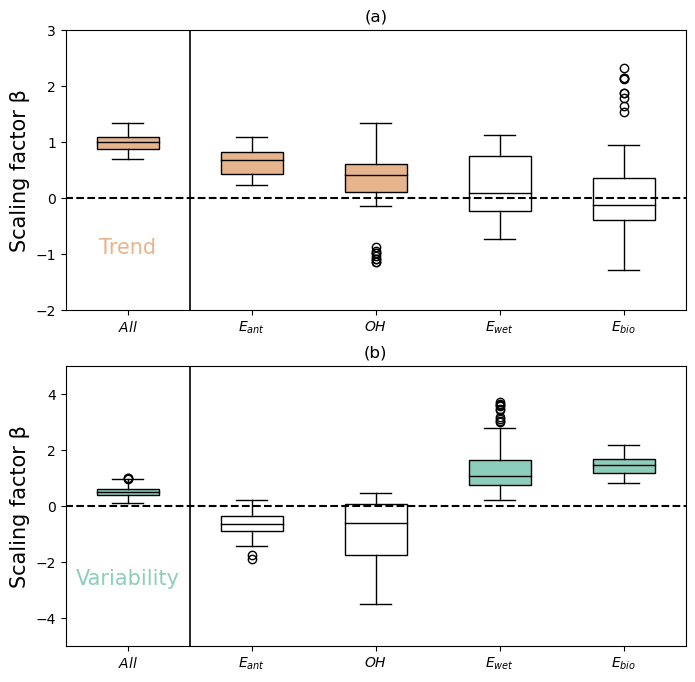

In [23]:
trend = np.concatenate([params_all_trend.T,params_trend.T]).T
variability = np.concatenate([params_all_variability.T,params_variability.T]).T

fig=plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((2,1),(0,0),rowspan=1)
bplot = ax1.boxplot(trend,patch_artist=True)
# temp = sns.violinplot(data=trend, bw_adjust=.5, cut=1, linewidth=1, palette=['#e7b58d','#e7b58d','#e7b58d','w','w'])
ax1.set_title('(a)')

for i in [0,1,2]:
    bplot['boxes'][i].set_facecolor('#e7b58d')
    bplot['medians'][i].set_color('k')
for i in [3,4]:
    bplot['boxes'][i].set_facecolor('w')
    bplot['medians'][i].set_color('k')


drivers = ['$All$']+['$E_{ant}$','$OH$','$E_{wet}$','$E_{bio}$']
ax1.set_xticklabels(drivers)

ax1.plot([-5,6],[0,0],color='k',linestyle='--')
ax1.set_xlim(0.5,5.5)

floor,ceil = -2,3
ax1.plot([1.5,1.5],[floor,ceil],linestyle='-',color='k',linewidth=1.2)
ax1.set_ylim(floor,ceil)
ax1.text(1,-1,'Trend',fontsize=15,ha= 'center',ma= 'center',
        color='#e7b58d')
ax1.set_ylabel('Scaling factor β',fontsize=15)
##############
##############
ax2 = plt.subplot2grid((2,1),(1,0),rowspan=1)
bplot = ax2.boxplot(variability,patch_artist=True)
for i in [0,3,4]:
    bplot['boxes'][i].set_facecolor('#8dcdbb')
    bplot['medians'][i].set_color('k')
for i in [1,2]:
    bplot['boxes'][i].set_facecolor('w')
    bplot['medians'][i].set_color('k')

# sns.violinplot(data=variability, bw_adjust=.5, cut=1, linewidth=1, palette=['#8dcdbb','w','w','#8dcdbb','#8dcdbb'],linecolor=['k'])
ax2.set_title('(b)')
ax2.set_xticklabels(drivers)
ax2.plot([-5,6],[0,0],color='k',linestyle='--')
ax2.set_xlim(0.5,5.5)
ax2.plot([1.5,1.5],[-10,10],linestyle='-',color='k',linewidth=1.2)
ax2.set_ylim(-5,5)
ax2.set_ylabel('Scaling factor β',fontsize=15)
ax2.text(1,-2.8,'Variability',fontsize=15,ha= 'center',ma= 'center',
        color='#8dcdbb')
fig.savefig('figs/Ext.Fig.2/MA.pdf',dpi=300)
fig.savefig('figs/Ext.Fig.2/MA.jpg',dpi=300)

# PWLF

In [43]:
trend_obs_PWLF = cal_trend_PWLF(obs_data)

In [44]:
trend_emi = []
for i in range(72):
    temp = cal_trend_PWLF(sim_emi_data[i])
    trend_emi.append(temp)
trend_emi_PWLF = np.array(trend_emi)

trend_oh = []
for i in range(72):
    temp = cal_trend_PWLF(sim_oh_data[i])
    trend_oh.append(temp)
trend_oh_PWLF = np.array(trend_oh)

trend_wet = []
for i in range(72):
    temp = cal_trend_PWLF(sim_wet_data[i])
    trend_wet.append(temp)
trend_wet_PWLF = np.array(trend_wet)

trend_bio = []
for i in range(72):
    temp = cal_trend_PWLF(sim_bio_data[i])
    trend_bio.append(temp)
trend_bio_PWLF = np.array(trend_bio)

In [45]:
params = []
for i in range(72):
    temp = np.array([trend_emi_PWLF[i,0,:],trend_oh_PWLF[i,0,:],trend_wet_PWLF[i,0,:],trend_bio_PWLF[i,0,:]])
    results = OLS(trend_obs_PWLF[0],temp.T)  
    params.append(results.params)
params_trend = np.array(params)

params = []

for i in range(72):
    temp = np.array([trend_emi_PWLF[i,1,:],trend_oh_PWLF[i,1,:],trend_wet_PWLF[i,1,:],trend_bio_PWLF[i,1,:]])
    results = OLS(trend_obs_PWLF[1],temp.T) 
    params.append(results.params)

params_variability = np.array(params)

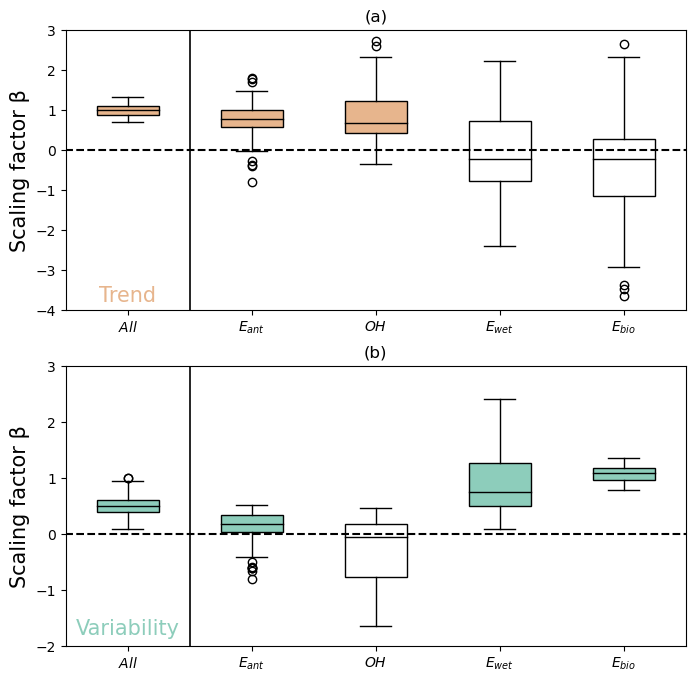

In [74]:
trend = np.concatenate([params_all_trend.T,params_trend.T]).T
variability = np.concatenate([params_all_variability.T,params_variability.T]).T

fig=plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((2,1),(0,0),rowspan=1)
bplot = ax1.boxplot(trend,patch_artist=True)
# temp = sns.violinplot(data=trend, bw_adjust=.5, cut=1, linewidth=1, palette=['#e7b58d','#e7b58d','#e7b58d','w','w'])
ax1.set_title('(a)')

for i in [0,1,2]:
    bplot['boxes'][i].set_facecolor('#e7b58d')
    bplot['medians'][i].set_color('k')
for i in [3,4]:
    bplot['boxes'][i].set_facecolor('w')
    bplot['medians'][i].set_color('k')


drivers = ['$All$']+['$E_{ant}$','$OH$','$E_{wet}$','$E_{bio}$']
ax1.set_xticklabels(drivers)

ax1.plot([-5,6],[0,0],color='k',linestyle='--')
ax1.set_xlim(0.5,5.5)

floor,ceil = -4,3
ax1.plot([1.5,1.5],[floor,ceil],linestyle='-',color='k',linewidth=1.2)
ax1.set_ylim(floor,ceil)
ax1.text(1,-3.8,'Trend',fontsize=15,ha= 'center',ma= 'center',
        color='#e7b58d')
ax1.set_ylabel('Scaling factor β',fontsize=15)
##############
##############
ax2 = plt.subplot2grid((2,1),(1,0),rowspan=1)
bplot = ax2.boxplot(variability,patch_artist=True)
for i in [0,3,4,1]:
    bplot['boxes'][i].set_facecolor('#8dcdbb')
    bplot['medians'][i].set_color('k')
for i in [2]:
    bplot['boxes'][i].set_facecolor('w')
    bplot['medians'][i].set_color('k')

# sns.violinplot(data=variability, bw_adjust=.5, cut=1, linewidth=1, palette=['#8dcdbb','w','w','#8dcdbb','#8dcdbb'],linecolor=['k'])
ax2.set_title('(b)')
ax2.set_xticklabels(drivers)
ax2.plot([-5,6],[0,0],color='k',linestyle='--')
ax2.set_xlim(0.5,5.5)
ax2.plot([1.5,1.5],[-10,10],linestyle='-',color='k',linewidth=1.2)
ax2.set_ylim(-2,3)
ax2.set_ylabel('Scaling factor β',fontsize=15)
ax2.text(1,-1.8,'Variability',fontsize=15,ha= 'center',ma= 'center',
        color='#8dcdbb')
fig.savefig('figs/Ext.Fig.2/PWLF.pdf',dpi=300)
fig.savefig('figs/Ext.Fig.2/PWLF.jpg',dpi=300)